# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 10.04.2023

Мягкий дедлайн: 24.04.2022 23:59 MSK

Жёсткий дедлайн: 30.04.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). 

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [40]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

In [41]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import folium
import numpy as np
import branca.colormap as cm
from sklearn.cluster import DBSCAN

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [44]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [155]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''
        
        D = np.diag(np.sum(X, axis=1))
        L = D - X
        
        eigenvalues, eigenvectors = np.linalg.eig(L)
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)

        idx = eigenvalues.argsort()[:self.n_components]
        eigenvectors_small = eigenvectors[:, idx]
        eigenvectors_small_norm = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 0, eigenvectors_small)

        return eigenvectors_small_norm
    

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [156]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [157]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [158]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [159]:
from scipy.spatial.distance import pdist, squareform

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''
    
    df = data[['ID_en', 'RouteNumbers_en']].copy()
    df = df.assign(RouteNumbers_en=df['RouteNumbers_en'].str.split('; '))
    df = df.explode('RouteNumbers_en')
    return df.groupby('RouteNumbers_en')['ID_en'].apply(list).to_dict()



def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    
    sorted_routes = {}
    for station, uns_stops in routes.items():
        selected_data = data.loc[data['ID_en'].isin(uns_stops), ['Longitude_WGS84_en','Latitude_WGS84_en']]
        #selected_data = data[data['ID_en'].isin(uns_stops)][['Longitude_WGS84_en','Latitude_WGS84_en']]
        unused_indexes = list(range(len(uns_stops)))
        dist = squareform(pdist(selected_data, metric='euclidean'))
        sorted_indexes = [np.argmax(dist.sum(axis=1))]
        while len(sorted_indexes) != len(uns_stops):
            cur_idx = sorted_indexes[-1]
            unused_indexes.remove(cur_idx)
            sorted_indexes.append(unused_indexes[np.argmin(dist[cur_idx][unused_indexes])])
        sorted_routes[station] = np.take(uns_stops, sorted_indexes)
    return sorted_routes


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''

    n = data.shape[0]
    adj_matrix = np.zeros((n,n))
    
    stops = np.sort(data['ID_en'].unique())
    id_stops = {val: idx for idx, val in enumerate(stops)}
    
    for key, route in sorted_routes.items():
        for i in range(1,len(route)):
            adj_matrix[id_stops[route[i]], id_stops[route[i-1]]] += 1
            adj_matrix[id_stops[route[i-1]], id_stops[route[i]]] += 1
    return adj_matrix

In [160]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [165]:
import numpy as np

list_colors = ['blue', 'green', 'cyan', 'yellow', 'magenta']
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

map = folium.Map([55.75215, 37.61819], zoom_start=12)
color = 0
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[data['ID_en'].isin(sorted_routes[route_id]), ['ID_en', 'Latitude_WGS84_en', 'Longitude_WGS84_en']]
    id_stops = {val: idx for idx, val in enumerate(sorted_routes[route_id])}
    coords['order'] = coords['ID_en'].map(id_stops)
    sorted_data = coords.sort_values(by='order')
    sorted_coords = sorted_data[['Latitude_WGS84_en', 'Longitude_WGS84_en']].values.tolist()

    folium.vector_layers.PolyLine(sorted_coords, color=color_dict[color]).add_to(map)
    color += 1
    
    folium.Circle(location=[sorted_data.iloc[0]['Latitude_WGS84_en'], sorted_data.iloc[0]['Longitude_WGS84_en']], 
                      radius=30,color='red').add_to(map)

    for i in range(1, len(sorted_data)):
        folium.Circle(location=[sorted_data.iloc[i]['Latitude_WGS84_en'], sorted_data.iloc[i]['Longitude_WGS84_en']], 
                      radius=5,color='black').add_to(map)

map

*кефтемеее, маршруты адекватные*

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [55]:
import branca.colormap as cm
def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''
    
    map = folium.Map([55.75215, 37.61819], zoom_start=12)
    label_set = np.unique(labels)
    label_set = label_set[label_set != -1]
    cmap = cm.linear.Set1_08.to_step(len(label_set)).scale(label_set.min(), label_set.max())
    for cluster in label_set:
        for id, row in data.loc[labels == cluster].iterrows():
            folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                          radius=10,color=cmap(cluster)).add_to(map)
    
    for id, row in data.loc[labels == -1].iterrows():
        folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                      radius=5,color='black').add_to(map)
        
    return map

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [56]:
from sklearn.cluster import DBSCAN

df = np.array(data[['Longitude_WGS84_en','Latitude_WGS84_en']])
kmeans = KMeans(8)
kmeans.fit(df)
draw_clustered_map(data, kmeans.labels_)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [57]:
dbscan = DBSCAN(eps=0.0036,metric='l2')
dbscan.fit(df)
draw_clustered_map(data,dbscan.labels_)

In [170]:
gr_cl = GraphClustering(50, 80)
gr_preds = gr_cl.fit_predict(adjacency_matrix)
draw_clustered_map(data,gr_preds)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:** 
K-means: разделяет Москву на конкретные, сегметрированные области, примерно одинаковой формы и размера.
Плюс данного алгоритма - сбалансированность получаемых кластеров. Но, в данном случае данный алгоритм не подходит, так как он разделят данные на кластеры одинакой округлой оформы, что не походит на маршруты транспортных средств в действительности (в реальности маршруты зачастую вытянутые).

DBSCAN: так же разделяет данные на сегментированные области, но уже разной формы и размера а так же, разной плотности.
Плюсы - умеет выделять кластеры разного размера, формы и плотности. Также выделяет и шумовые точки, что помогает достичь более точной кластеризации. Но, полученные кластеры всё ещё не похожи на действительное распределение остановочных маршрутов, так как кластеры слишком сильно отличаются по размеру.


Cпектральная кластеризация: остановки разделяются на кластеры, более походящие на маршруты транспортных средств (кольцевая линия, несколько крастеров со следующей структурой: несколько лучей, исходящих от центра).
Минусы: дольше работает, не устойчева к изменению обучающих данных.

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [177]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
1452     sport  140.txt   Chelsea ridiculed over complaint   
27    business  028.txt   Strong demand triggers oil rally   
1317     sport  005.txt  Dibaba breaks 5,000m world record   
1615     sport  303.txt    Jones happy with Henson heroics   
1397     sport  085.txt   Tulu to appear at Caledonian run   

                                                content  
1452   Barcelona assistant coach Henk Ten Cate has b...  
27     Crude oil prices surged back above the $47 a ...  
1317   Ethiopia's Tirunesh Dibaba set a new world re...  
1615   Wales fly-half Stephen Jones admitted he was ...  
1397   Two-time Olympic 10,000 metres champion Derar...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [178]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [179]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [181]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [182]:
!pip install wordcloud

In [183]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

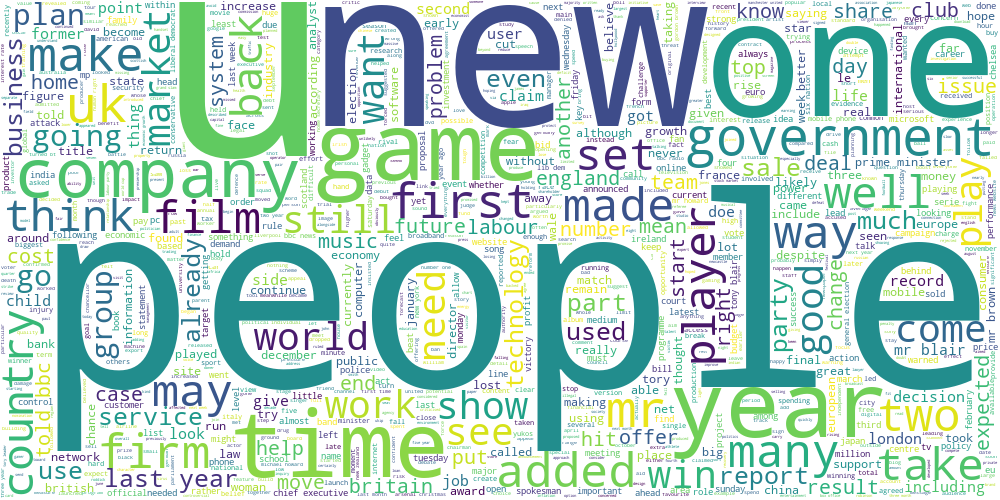

In [184]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:** темы хорошо интерпретируются (смотреть ниже)

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(min_df=0.05)
tf_idf.fit(data['text'])

km_text = KMeans(8)
tf_idf_data = tf_idf.transform(data['text']).toarray()
km_text.fit(tf_idf_data)

KMeans()

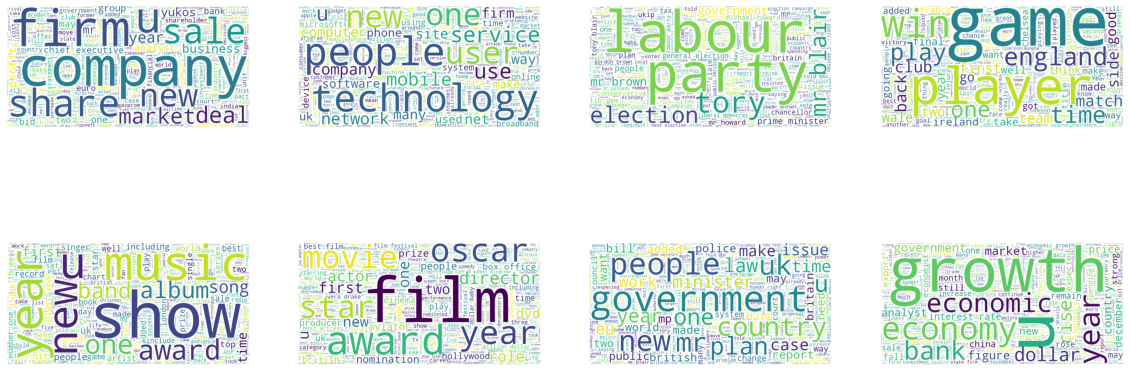

In [186]:
import matplotlib.pyplot as plt

# Создаем холст с 8 графиками в 2 строки и 4 столбца
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# Отображаем каждое изображение на своем графике
axs[0, 0].imshow(draw_wordcloud(data[km_text.labels_==0].text))
axs[0, 1].imshow(draw_wordcloud(data[km_text.labels_==1].text))
axs[0, 2].imshow(draw_wordcloud(data[km_text.labels_==2].text))
axs[0, 3].imshow(draw_wordcloud(data[km_text.labels_==3].text))
axs[1, 0].imshow(draw_wordcloud(data[km_text.labels_==4].text))
axs[1, 1].imshow(draw_wordcloud(data[km_text.labels_==5].text))
axs[1, 2].imshow(draw_wordcloud(data[km_text.labels_==6].text))
axs[1, 3].imshow(draw_wordcloud(data[km_text.labels_==7].text))

# Убираем оси на всех графиках
for ax in axs.flatten():
    ax.axis('off')

# Показываем холст с графиками
plt.show()


1. business/finance 
2. technology/mobile devices
3. politics/government
4. sports
5. entertainment/music
6. entertainment/movies
7. politics/government
8. finance/economics

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ** Вывели по 5 наиболее вероятных члов для каждого кластера. Видно, что слова согласуются с облаками тегов.

In [187]:
words = np.array(tf_idf.get_feature_names())
words[km_text.cluster_centers_.argsort(axis=1)[:,-5:]]

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([['profit', 'sale', 'share', 'firm', 'company'],
       ['phone', 'mobile', 'user', 'people', 'technology'],
       ['tory', 'election', 'party', 'labour', 'mr'],
       ['match', 'win', 'england', 'player', 'game'],
       ['star', 'year', 'award', 'music', 'show'],
       ['director', 'actor', 'best', 'award', 'film'],
       ['law', 'minister', 'would', 'government', 'mr'],
       ['economic', 'price', 'rate', 'growth', 'economy']], dtype='<U13')

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [188]:
from sklearn.cluster import SpectralClustering

km = KMeans(6)
km.fit(tf_idf_data)

sp = SpectralClustering(6)
sp.fit(tf_idf_data)

SpectralClustering(n_clusters=6)

In [189]:
for min_pts in range(7, 15):
    for eps in np.logspace(-2, 1, 50):
        db = DBSCAN(eps=eps, min_samples=min_pts).fit(tf_idf_data).labels_
        if len(np.unique(db[db != -1])) in [4,5,6,7]:
            print('min_pts = %d, eps = %.3f, n = %d' % (min_pts, eps, len(np.unique(db[db != -1]))))
        

min_pts = 7, eps = 0.791, n = 5
min_pts = 8, eps = 0.791, n = 5
min_pts = 9, eps = 0.791, n = 4
min_pts = 10, eps = 0.791, n = 4
min_pts = 11, eps = 0.910, n = 6
min_pts = 12, eps = 0.910, n = 6
min_pts = 13, eps = 0.910, n = 4
min_pts = 14, eps = 0.910, n = 4


In [190]:
db = DBSCAN(eps=0.791, min_samples=7)
db.fit(tf_idf_data)

DBSCAN(eps=0.791, min_samples=7)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


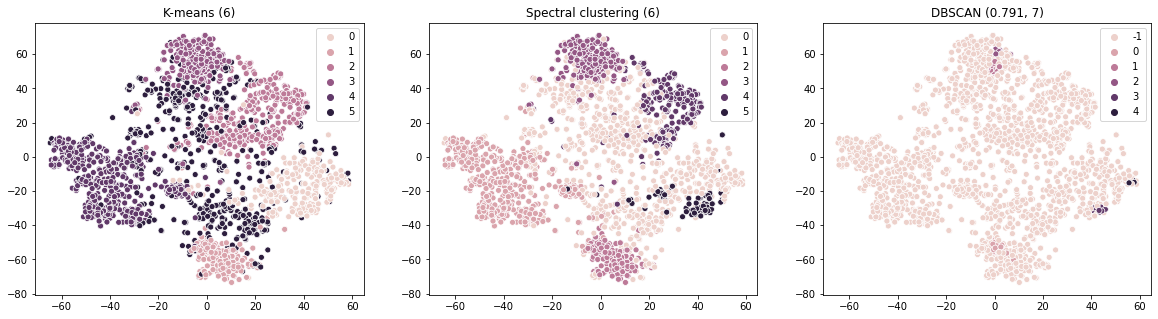

In [191]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(2)
X_emb = tsne.fit_transform(tf_idf_data)

fig, axs = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=km.labels_, ax=axs[0], legend='full')
axs[0].set_title('K-means (6)')
sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=sp.labels_, ax=axs[1], legend='full')
axs[1].set_title('Spectral clustering (6)')
sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=db.labels_, ax=axs[2], legend='full')
axs[2].set_title('DBSCAN (0.791, 7)')
plt.show()

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:** У DBSCAN (с требуемыми по условию параметрами) кластеризация получилась плохого качества. Практически все данные причесляются к шумовым, останые кластеры - маленькие и плотные.

K-Means отрабатыкает похожим образом, как и в первом задании, разделяя данные на конкретные, сегметрированные области, примерно одинаковой формы. Но размер между отдельными кластерами льличаются (а так же, кластер 5 имеет инную форму), пллотность кластеров так же отличаются (в географических данным была инная картина).

Спектральная кластеризация в данном случае сильно отличаётся от работы на гегографических данных. Сдесь данные уже разделяются на сегментированные области. Можно засметить, что кластеры 1, 2, 3, 4 примерно совпадают с соотвествующими кластерами в K-Means. Так же, данные уже не имею такой витянутой структуры, как в первом задании (что объясняётся видом данных).

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [192]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=0.05)),
    ('lda', LatentDirichletAllocation(n_components=15))
])

topics = pipeline.fit_transform(data.text).argmax(axis=1)

In [193]:
for cluster in np.unique(topics):
    print('Cluster %d' % cluster)
    print(data[topics==cluster].text.head())
    print('\n')

Cluster 0
618    band aid retains number one spot charity singl...
621    elvis set top uk single chart rock n roll lege...
635    dove soar uk album summit manchester rock band...
638    brit return keane number one brit success help...
653    eminem beat elvis number one rapper eminem den...
Name: text, dtype: object


Cluster 1
2     yukos unit buyer face loan claim owner embattl...
4     pernod takeover talk lift domecq share uk drin...
9     court reject tobacco case u government claim a...
10    ask jeeves tip online ad revival ask jeeves be...
12    peugeot deal boost mitsubishi struggling japan...
Name: text, dtype: object


Cluster 2
805     snow patrol bassist exit group snow patrol cou...
1035    uk help raped rwandan woman britain give grant...
1313    claxton hunting first major medal british hurd...
1315    greene set sight world title maurice greene ai...
1317    dibaba break world record ethiopia tirunesh di...
Name: text, dtype: object


Cluster 3
86     worldcom bos b

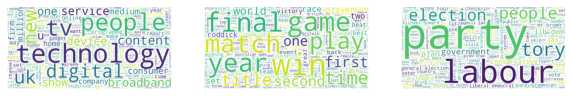

In [129]:
import matplotlib.pyplot as plt

# Создаем холст с тремя графиками в 1 строку и 3 столбца
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Отображаем каждое облако слов на своем графике
axs[0].imshow(draw_wordcloud(data[topics==0].text))
axs[1].imshow(draw_wordcloud(data[topics==1].text))
axs[2].imshow(draw_wordcloud(data[topics==2].text))

# Убираем оси на всех графиках
for ax in axs:
    ax.axis('off')

# Показываем холст с графиками
plt.show()


## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(data.category)
X_train, X_test, y_train, y_test = train_test_split(data.text, y, test_size=0.3)

Logreg + tf-idf

In [202]:
from sklearn.metrics import accuracy_score

lr_tf_idf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

lr_tf_idf.fit(X_train, y_train)
print('\nTrain accuracy: %.4f\tTest accuracy %.4f' % (accuracy_score(y_train, lr_tf_idf.predict(X_train)),
                                                     accuracy_score(y_test, lr_tf_idf.predict(X_test))))


Train accuracy: 0.9955	Test accuracy 0.9760


tf-idf + K-means + Logreg

In [203]:
km_lr = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('kmeans', KMeans()),
    ('logreg', LogisticRegression())
])

km_lr.fit(X_train, y_train)
print('\nTrain accuracy: %.4f\tTest accuracy %.4f' % (accuracy_score(y_train, km_lr.predict(X_train)),
                                                     accuracy_score(y_test, km_lr.predict(X_test))))


Train accuracy: 0.8459	Test accuracy 0.8458


LDA + Logreg


In [204]:
lda_lr = Pipeline([
    ('bow', CountVectorizer()),
    ('lda', LatentDirichletAllocation()),
    ('logreg', LogisticRegression())
])

lda_lr.fit(X_train, y_train)
print('\nTrain accuracy: %.4f\tTest accuracy %.4f' % (accuracy_score(y_train, lda_lr.predict(X_train)),
                                                     accuracy_score(y_test, lda_lr.predict(X_test))))


Train accuracy: 0.8581	Test accuracy 0.9311


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** 
Лучшее качество у Logreg + tf-idf. Это может происходить из-за того, что на данной размеченной выборки модель хорошо строет приблежение прадоподобия распределения тем, что сказывается и на хорошом качестве отрабатывания модели на тестовых данных.

LDA + Logreg отрабатывает уже хуже. Из-за использования LDA модель становится сложно интерпретируемой.

tf-idf + K-means + Logreg - худшее качество. Видимо это связвно с тем, что разбиения выборки случайно (так же не факт, что кластеры должны быть примерно одной формы и размера).

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [215]:
from sklearn.model_selection import train_test_split

# разделяем обучающую выборку на размеченный трейн и оставшиеся данные
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.95, random_state=42)

# разделяем оставшиеся данные на неразмеченный трейн и валидационную выборку
X_unlabeled, X_val, y_unlabeled, y_val = train_test_split(X_unlabeled, y_unlabeled, test_size=0.31, random_state=42)

In [217]:
best_params = None
max_val_score = 0
for n in tqdm(np.arange(25, 40, 1)):
    for C in  np.logspace(1, 4, 20):
        km_3_2 = Pipeline([
            ('tf_idf', TfidfVectorizer(min_df=0.01)),
            ('kmeans', KMeans(n))
        ])
        km_3_2.fit(pd.concat((X_labeled, X_unlabeled)))
        lr = LogisticRegression(C=C, max_iter=10000)
        lr.fit(km_3_2.transform(X_labeled), y_labeled)
        val_pred = lr.predict(km_3_2.transform(X_val))
        if accuracy_score(y_val, val_pred) > max_val_score:
            max_val_score = accuracy_score(y_val, val_pred)
            best_params = (n, C)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:44<00:00, 26.98s/it]


In [218]:
best_params

(36, 1623.776739188721)

In [219]:
km_3_2 = Pipeline([
    ('tf_idf', TfidfVectorizer(min_df=0.01)),
    ('kmeans', KMeans(best_params[0]))
])

km_3_2.fit(pd.concat((X_labeled, X_unlabeled)))
lr_km_3_2 = LogisticRegression(C=best_params[1], max_iter=10000)
lr_km_3_2.fit(km_3_2.transform(X_labeled), y_labeled)
pred_km = lr_km_3_2.predict(km_3_2.transform(X_test))
train_pred_km = lr_km_3_2.predict(km_3_2.transform(X_labeled))
print('train accuracy: %.4f,\tTest accuracy: %.4f' % 
      (accuracy_score(y_labeled, train_pred_km), accuracy_score(y_test, pred_km)))

train accuracy: 1.0000,	Test accuracy: 0.9341


In [208]:
best_params_lda = None
max_val_score = 0
for n in tqdm(np.arange(2, 30, 2)):
    for C in np.logspace(-1, 4, 20):
        lda_3_2 = Pipeline([
            ('bow', CountVectorizer(min_df=0.01)),
            ('lda', LatentDirichletAllocation(n))
        ])
        lda_3_2.fit(pd.concat((X_labeled, X_unlabeled)))
        lr = LogisticRegression(C=C, max_iter=10000)
        lr.fit(lda_3_2.transform(X_labeled), y_labeled)
        val_pred = lr.predict(lda_3_2.transform(X_val))
        if accuracy_score(y_val, val_pred) > max_val_score:
            max_val_score = accuracy_score(y_val, val_pred)
            best_params_lda = (n, C)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [22:29<00:00, 96.42s/it]


In [211]:
best_params_lda

(6, 2.0691380811147893)

In [212]:
lda_3_2 = Pipeline([
    ('bow', CountVectorizer(min_df=0.01)),
    ('lda', LatentDirichletAllocation(best_params_lda[0]))
])
lda_3_2.fit(pd.concat((X_labeled, X_unlabeled)))
lr = LogisticRegression(C=best_params_lda[1], max_iter=10000)
lr.fit(lda_3_2.transform(X_labeled), y_labeled)
print('train accuracy: %.4f,\tTest accuracy: %.4f' % 
      (accuracy_score(y_labeled, lr.predict(lda_3_2.transform(X_labeled))), 
       accuracy_score(y_test, lr.predict(lda_3_2.transform(X_test)))))

train accuracy: 0.9610,	Test accuracy: 0.9341


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** 
Logreg + tf-idf:

Было: Train accuracy: 0.9955	Test accuracy 0.9760

Стало: train accuracy: 1.0000,	Test accuracy: 0.9341

Произошло лютое переобучение(


LDA + Logreg:

Было: Train accuracy: 0.8581	Test accuracy 0.9311

Стало: train accuracy: 0.9610,	Test accuracy: 0.9341

Переобучения не произошло) Правда качество на тестовой выборке практически не изменилось


Вывод: черезмерно увлекаться подбором гиперпараметров не стоит, произойдёт переобучение. Стоит проводить анализ предоставленных данных, для примерного понимания о разумном количестве кластеров и для лучшего подбора модели для конкретной задачи.

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [220]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier

*Приведение матрицы к плотному виду взял отсюда*

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [221]:
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

**LabelPropagation**

In [223]:
best_params_lp_rbf = None
max_val_score = 0
for gamma in tqdm(np.logspace(1, 3, 40)):
    lp = Pipeline([
        ('tf_idf', TfidfVectorizer(min_df=0.01)),
        ('to_dense', DenseTransformer()), 
        ('label_prop', LabelPropagation(gamma=gamma, max_iter=1000))
    ])
    
    lp.fit(pd.concat((X_labeled, X_unlabeled)), 
           np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))
    
    if accuracy_score(y_val, lp.predict(X_val)) > max_val_score:
        max_val_score = accuracy_score(y_val, lp.predict(X_val))
        best_params_lp_rbf = gamma

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\valida

 22%|██████████████████▋                                                                | 9/40 [00:18<00:41,  1.33s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 25%|████████████████████▌                                                             | 10/40 [00:19<00:34,  1.16s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated 

 50%|█████████████████████████████████████████                                         | 20/40 [00:27<00:15,  1.31it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 52%|███████████████████████████████████████████                                       | 21/40 [00:28<00:14,  1.27it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated 

 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:36<00:06,  1.34it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:37<00:06,  1.27it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated 

In [226]:
print('best gamma: %.4f' % best_params_lp_rbf)
lp = Pipeline([
    ('tf_idf', TfidfVectorizer(min_df=0.01)),
    ('to_dense', DenseTransformer()),
    ('label_prop', LabelPropagation(gamma=best_params_lp_rbf, max_iter=1000))
])
lp.fit(pd.concat((X_labeled, X_unlabeled)), 
       np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))

print('train score: %.4f' % accuracy_score(y_labeled,lp.predict(X_labeled)))
print('Test score: %.4f' % accuracy_score(y_test,lp.predict(X_test)))

best gamma: 11.2534


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a

train score: 1.0000
Test score: 0.9147


In [229]:
best_params_ls_rbf = None
max_val_score = 0
for gamma in tqdm(np.logspace(1, 3, 40)):
    ls = Pipeline([
        ('tf_idf', TfidfVectorizer(min_df=0.01)),
        ('to_dense', DenseTransformer()),
        ('label_spread', LabelSpreading(gamma=gamma))
    ])
    ls.fit(pd.concat((X_labeled, X_unlabeled)), 
           np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))
    if accuracy_score(y_val, ls.predict(X_val)) > max_val_score:
        max_val_score = accuracy_score(y_val, ls.predict(X_val))
        best_params_ls_rbf = gamma

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 28%|██████████████████████▌                                                           | 11/40 [00:06<00:17,  1.63it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 55%|█████████████████████████████████████████████                                     | 22/40 [00:13<00:11,  1.58it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:20<00:04,  1.55it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

**LabelSpreading**

In [232]:
print('best gamma: %.4f' % best_params_ls_rbf)
ls = Pipeline([
    ('tf_idf', TfidfVectorizer(min_df=0.01)),
    ('to_dense', DenseTransformer()),
    ('label_spread', LabelSpreading(gamma=best_params_ls_rbf))
])
ls.fit(pd.concat((X_labeled, X_unlabeled)), 
       np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))

print('train score: %.4f' % accuracy_score(y_labeled,ls.predict(X_labeled)))
print('Test score: %.4f' % accuracy_score(y_test, ls.predict(X_test)))

best gamma: 10.0000


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


train score: 1.0000
Test score: 0.8847


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


**SelfTrainingClassifier**

This metaestimator allows a given supervised classifier to function as a semi-supervised classifier, allowing it to learn from unlabeled data. It does this by iteratively predicting pseudo-labels for the unlabeled data and adding them to the training set.

То есть в эту модель в качестве параметра нужно подавать клссификатор. Скормим ему SVM и RandomForestClassifier. 

SVM
(остановил подбор параметра на 84%, долго учится, времени до дедлайна мало)

In [236]:
from sklearn.svm import SVC

best_C_svm = None
max_val_score = 0
for C in tqdm(np.logspace(-1, 3, 25)):
    stc = Pipeline([
        ('tf_idf', TfidfVectorizer(min_df=0.01)),
        ('to_dense', DenseTransformer()),
        ('self_svm', SelfTrainingClassifier(SVC(C=C, probability=True)))
    ])
    stc.fit(pd.concat((X_labeled, X_unlabeled)), 
       np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))

    if accuracy_score(y_val, stc.predict(X_val)) > max_val_score:
        max_val_score = accuracy_score(y_val, stc.predict(X_val))
        best_C_svm = C

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

 36%|█████████████████████████████▉                                                     | 9/25 [03:34<12:32, 47.05s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 40%|████████████████████████████████▊                                                 | 10/25 [04:45<13:31, 54.13s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated 

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [24:56<13:50, 166.14s/it]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

KeyboardInterrupt: 

In [237]:
print('best C: %.4f' % best_C_svm)
self_svm = Pipeline([
    ('tf_idf', TfidfVectorizer(min_df=0.01)),
    ('to_dense', DenseTransformer()),
    ('self_svm', SelfTrainingClassifier(SVC(C=best_C_svm,probability=True)))
])
self_svm.fit(pd.concat((X_labeled, X_unlabeled)), 
       np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))

print('Labeled train score: %.4f' % accuracy_score(y_labeled, self_svm.predict(X_labeled)))
print('Test score: %.4f' % accuracy_score(y_test,self_svm.predict(X_test)))

best C: 100.0000


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Labeled train score: 1.0000


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Test score: 0.9416


RandomForestClassifier (не успел прогнать)

In [256]:
from sklearn.ensemble import RandomForestClassifier

best_params_self_rf = None
max_val_score = 0
for n in tqdm(np.logspace(1, 2, 4)):
    for split in np.arange(3, 10):
        for min_leaf in np.arange(1, 5):
            self_rf = Pipeline([
                ('tf_idf', TfidfVectorizer(min_df=0.01)),
                ('to_dense', DenseTransformer()),
                ('self_rf', SelfTrainingClassifier(
                    RandomForestClassifier(n_estimators=int(n), 
                                           min_samples_split=split, 
                                           min_samples_leaf=min_leaf)))
            ])
            self_rf.fit(pd.concat((X_labeled, X_unlabeled)), 
               np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))
            
            if accuracy_score(y_val, self_rf.predict(X_val)) > max_val_score:
                max_val_score = accuracy_score(y_val, self_rf.predict(X_val))
                best_params_self_rf = (int(n), split, min_leaf)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: ht

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-pack

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-pack

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-pack

KeyboardInterrupt: 

In [258]:
print('best n_est, min_split, min_leaf: %d %d %d' % best_params_self_rf)
self_rf = Pipeline([
    ('tf_idf', TfidfVectorizer(min_df=0.01)),
    ('to_dense', DenseTransformer()),
    ('self_rf', SelfTrainingClassifier(RandomForestClassifier(n_estimators=best_params_self_rf[0], 
                                                              min_samples_split=best_params_self_rf[1],
                                                              min_samples_leaf=best_params_self_rf[2])))
])
self_rf.fit(pd.concat((X_labeled, X_unlabeled)), 
       np.concatenate((y_labeled, -np.ones(X_unlabeled.shape[0]))))

print('train score: %.4f' % accuracy_score(y_labeled,self_rf.predict(X_labeled)))
print('Test score: %.4f' % accuracy_score(y_test, self_rf.predict(X_test)))

best n_est, min_split, min_leaf: 21 3 3


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


train score: 0.6494
Test score: 0.2829


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [252]:
def bcubed(y, pred):
    pre = np.mean([np.mean([(y[x_1] == y[x_2]) for x_2 in range(len(pred)) if (pred[x_1] == pred[x_2])]) 
         for x_1 in range(len(pred))]) 
    rec = np.mean([np.mean([(pred[x_1] == pred[x_2]) for x_2 in range(len(pred)) if (y[x_1] == y[x_2])]) 
         for x_1 in range(len(pred))])
    return 2 * pre * rec / (pre + rec)

из задания 3.1

In [253]:
print('Logreg + tf-idf')
print('\nBCubed: %.4f' % bcubed(y, lr_tf_idf.predict(data.text)))

print('tf-idf + K-means + LR')
print('\nBCubed: %.4f' % bcubed(y, km_lr.predict(data.text)))

print('BOW + LDA + LR')
print('\nBCubed: %.4f' % bcubed(y, lda_lr.predict(data.text)))

Logreg + tf-idf

BCubed: 0.9795
tf-idf + K-means + LR

BCubed: 0.7533
BOW + LDA + LR

BCubed: 0.7841


**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿